In [93]:
import warnings
warnings.filterwarnings('ignore')

In [94]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

import matplotlib.pyplot as plt
import seaborn as sns


In [95]:
from datetime import datetime, timedelta

import talib

from tumbler.constant import Interval
from tumbler.service.mysql_service import MysqlService
from tumbler.object import BarData, FactorData

use_start_time = datetime(2017, 1, 1)
use_end_time = datetime.now() + timedelta(hours=10)


def create_df(suffix="_usdt"):
    global use_start_time, use_end_time
    mysql_service_manager = MysqlService.get_mysql_service()
    symbols = mysql_service_manager.get_mysql_distinct_symbol(table=MysqlService.get_kline_table(Interval.DAY.value))
    symbols = [x for x in symbols if
                   x.endswith(suffix) and not x.endswith("down_usdt")
                   and not x.endswith("up_usdt") and not x.endswith("bear_usdt") 
                   and not x in ["drep_usdt", "cocos_usdt"]]
    bars = mysql_service_manager.get_bars(symbols=[], period=Interval.DAY.value,
                                          start_datetime=use_start_time,
                                          end_datetime=use_end_time,
                                          sort_way="symbol")

    bars = BarData.suffix_filter(bars, suffix="_usdt")
    bars.sort()

    pd_data = BarData.get_pandas_from_bars(bars)
    pd_data = pd_data.set_index(["symbol", "datetime"]).sort_index().reset_index()
    
    return pd_data


def merge_factor(df, factor_codes):
    global use_start_time, use_end_time
    if isinstance(factor_codes, str):
        factor_codes = [factor_codes]
    mysql_service_manager = MysqlService.get_mysql_service()
    factor_ret = mysql_service_manager.get_factors(
        factor_codes=factor_codes,
        interval=Interval.DAY.value,
        start_dt=use_start_time,
        end_dt=use_end_time
    )
    for factor_code in factor_codes:
        print(factor_code)
        factor_df = FactorData.get_factor_df(factor_ret, factor_code)
        df = pd.merge(df, factor_df, how='left', left_on=['symbol', 'datetime'], right_on=['symbol', 'datetime'])

#         rank_code = f"rank_{factor_code}"
#         df[rank_code] = df.groupby(by=['datetime']).apply(
#             lambda x: pd.DataFrame(pd.qcut(df[factor_code], [0, 0.2, 0.4, 0.6, 0.8, 1.0]
#                                            , labels=[rank_code + "_1", rank_code + "_2",
#                                                      rank_code + "_3", rank_code + "_4",
#                                                      rank_code + "_5"
#                                                      ]), index=x.index))
        
    return df
    
    
def make_feature(df):
    factor_codes = []
    factor_codes += ["DROC5", "DROC10", "DROC20", "DROC30", "DROC60", "DROC90"]
    factor_codes += ["ER10", "ER20", "ER30", "ER60", "ER90", "ER120"]
    factor_codes += ["DER10", "DER20", "DER30", "DER60", "DER90", "DER120"]
    factor_codes += ["ROC1", "ROC3", "ROC5", "ROC10", "ROC20", "ROC30", "ROC60", "ROC90"]
    factor_codes += ["SIZE"]
    factor_codes += ["BOLL_UPPER", "BOLL_MIDDLE", "BOLL_LOWER"]
    factor_codes += ["MACD", "MACDSIGNAL", "MACDHIST"]
    factor_codes += ["MA5", "MA10", "MA20", "MA30", "MA60", "MA120"]
    factor_codes += ["NATR", "NEGNATR", "PPO", "MOM", "WMA", "HT_TRENDLINE", "EMA", "CCI", "CMO"]
    factor_codes += ["ADOSC", "ADX", "WILLR", "RSI14", "TRIX14", "SAR", "AROON_UP", "AROON_DOWN"]
    factor_codes += ["BOP", "SLOWD", "ULTOSC", "AD", "OBV", "ATR"]

    df = merge_factor(df, factor_codes)
    return df


def get_factor_codes():
    mysql_service = MysqlService()
    conn = mysql_service.get_conn()
    sqll = "select distinct factor_code from factor_1day"
    cur = conn.cursor()
    cur.execute(sqll)

    my_result = cur.fetchall()
    factor_codes = [x[0] for x in my_result]
    
    cur.close()
    conn.close()
    return factor_codes


# def make_feature(df):
#     factor_codes = get_factor_codes()
    
#     df = merge_factor(df, factor_codes)
#     return df


def make_target(df, num_day_rise=1):
    df["target"] = df.groupby(by=['symbol']).apply(
        lambda x: pd.DataFrame(pd.Series(talib.ROC(x.close, num_day_rise)).shift(-1 * num_day_rise), index=x.index)
    )
    return df


def split_train_test(df, split_datetime=datetime(2021, 5, 1)):
    train_df = df[df.datetime <= split_datetime].copy()
    test_df = df[df.datetime > split_datetime].copy()
    
    return train_df, test_df


In [96]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()

In [110]:
df = create_df()
print(df)

df = make_feature(df)
print(df)

df = make_target(df, num_day_rise=5)
df.to_csv("target_df.csv")
print(df)

df=df.dropna(axis=0,how='any')

train, test = split_train_test(df)

fwd_returns = df.filter(like='target').columns
print(fwd_returns)

features = df.columns.difference(pd.Index(list(fwd_returns) + ['symbol', 'datetime', 'exchange', 'open', 'high', 'low', 'close', 'volume'])).tolist()
print(features)

alphas = features
print(features)
print(len(alphas))


            symbol            datetime exchange    open    high     low  \
0       1inch_usdt 2020-12-25 08:00:00  BINANCE  0.2000  3.0885  0.2000   
1       1inch_usdt 2020-12-26 08:00:00  BINANCE  2.2958  2.4609  1.5717   
2       1inch_usdt 2020-12-27 08:00:00  BINANCE  1.5970  1.6516  1.0360   
3       1inch_usdt 2020-12-28 08:00:00  BINANCE  1.0600  1.2787  1.0353   
4       1inch_usdt 2020-12-29 08:00:00  BINANCE  1.1140  1.1166  0.7541   
...            ...                 ...      ...     ...     ...     ...   
124933    zrx_usdt 2021-08-24 08:00:00  BINANCE  1.1597  1.1887  1.0310   
124934    zrx_usdt 2021-08-25 08:00:00  BINANCE  1.0614  1.1743  1.0134   
124935    zrx_usdt 2021-08-26 08:00:00  BINANCE  1.1500  1.1681  1.0177   
124936    zrx_usdt 2021-08-27 08:00:00  BINANCE  1.0475  1.1123  1.0028   
124937    zrx_usdt 2021-08-28 08:00:00  BINANCE  1.1114  1.1130  1.0697   

         close        volume  
0       2.2954  1.259776e+08  
1       1.5967  5.703970e+07  
2     

Index(['target'], dtype='object')
['AD', 'ADOSC', 'ADX', 'AROON_DOWN', 'AROON_UP', 'ATR', 'BOLL_LOWER', 'BOLL_MIDDLE', 'BOLL_UPPER', 'BOP', 'CCI', 'CMO', 'DER10', 'DER120', 'DER20', 'DER30', 'DER60', 'DER90', 'DROC10', 'DROC20', 'DROC30', 'DROC5', 'DROC60', 'DROC90', 'EMA', 'ER10', 'ER120', 'ER20', 'ER30', 'ER60', 'ER90', 'HT_TRENDLINE', 'MA10', 'MA120', 'MA20', 'MA30', 'MA5', 'MA60', 'MACD', 'MACDHIST', 'MACDSIGNAL', 'MOM', 'NATR', 'NEGNATR', 'OBV', 'PPO', 'ROC1', 'ROC10', 'ROC20', 'ROC3', 'ROC30', 'ROC5', 'ROC60', 'ROC90', 'RSI14', 'SAR', 'SIZE', 'SLOWD', 'TRIX14', 'ULTOSC', 'WILLR', 'WMA']
['AD', 'ADOSC', 'ADX', 'AROON_DOWN', 'AROON_UP', 'ATR', 'BOLL_LOWER', 'BOLL_MIDDLE', 'BOLL_UPPER', 'BOP', 'CCI', 'CMO', 'DER10', 'DER120', 'DER20', 'DER30', 'DER60', 'DER90', 'DROC10', 'DROC20', 'DROC30', 'DROC5', 'DROC60', 'DROC90', 'EMA', 'ER10', 'ER120', 'ER20', 'ER30', 'ER60', 'ER90', 'HT_TRENDLINE', 'MA10', 'MA120', 'MA20', 'MA30', 'MA5', 'MA60', 'MACD', 'MACDHIST', 'MACDSIGNAL', 'MOM', 'NATR

In [111]:
# compute corr information
corr_common = df.drop(fwd_returns.union(alphas), axis=1).corr(method='spearman')
corr_common.to_hdf('data.h5', 'correlation/common')
corr_ = corr_common.stack().reset_index()
corr_.columns = ['x1', 'x2', 'rho']
corr_ = corr_[corr_.x1!=corr_.x2].drop_duplicates('rho')
corr_.nlargest(5, columns='rho').append(corr_.nsmallest(5, columns='rho'))

,x1,x2,rho
8,high,close,0.999846
13,low,close,0.999823
2,open,low,0.999789
1,open,high,0.999770
3,open,close,0.999726
14,low,volume,-0.788557
4,open,volume,-0.787203
19,close,volume,-0.786121
9,high,volume,-0.784388
7,high,low,0.999623


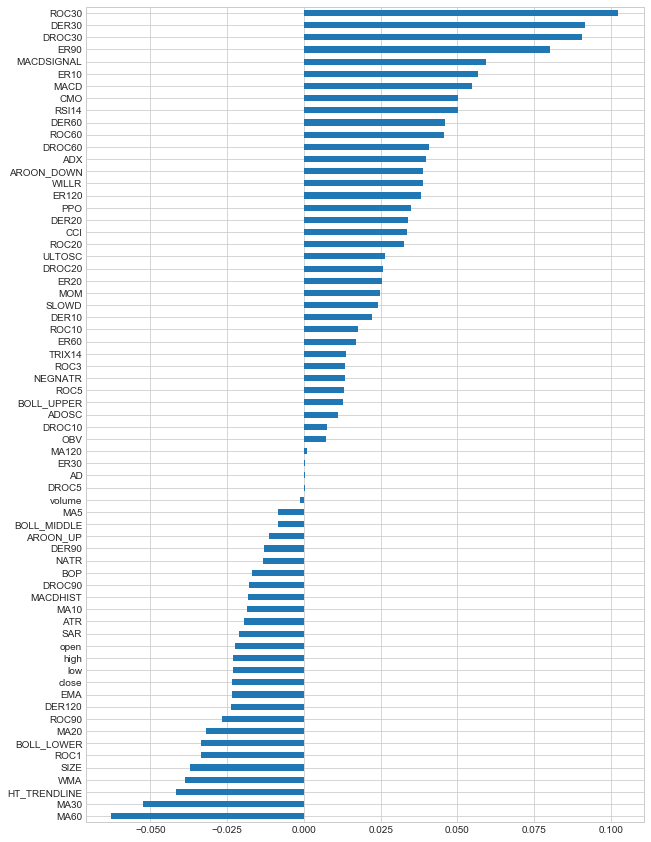

In [112]:
fwd_corr = df.drop(['target'], axis=1).corrwith(df.target, method='spearman')

top500 = fwd_corr.abs().nlargest(500).index
fwd_corr.loc[top500].sort_values().plot.barh(figsize=(10, 15), legend=False);

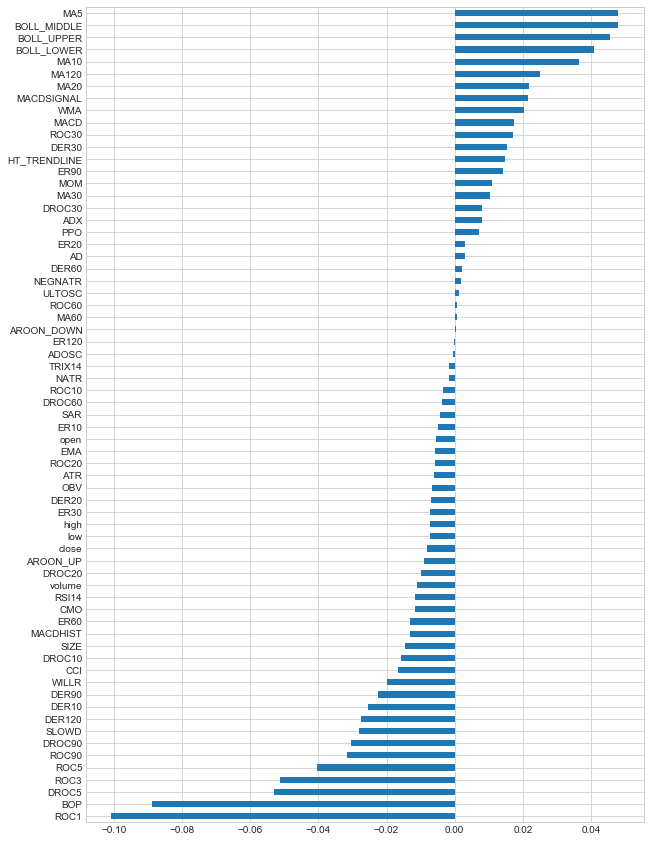

In [109]:
fwd_corr = df.drop(['target'], axis=1).corrwith(df.target, method='spearman')

top500 = fwd_corr.abs().nlargest(500).index
fwd_corr.loc[top500].sort_values().plot.barh(figsize=(10, 15), legend=False);

100%|██████████| 62/62 [09:34<00:00,  9.26s/it]


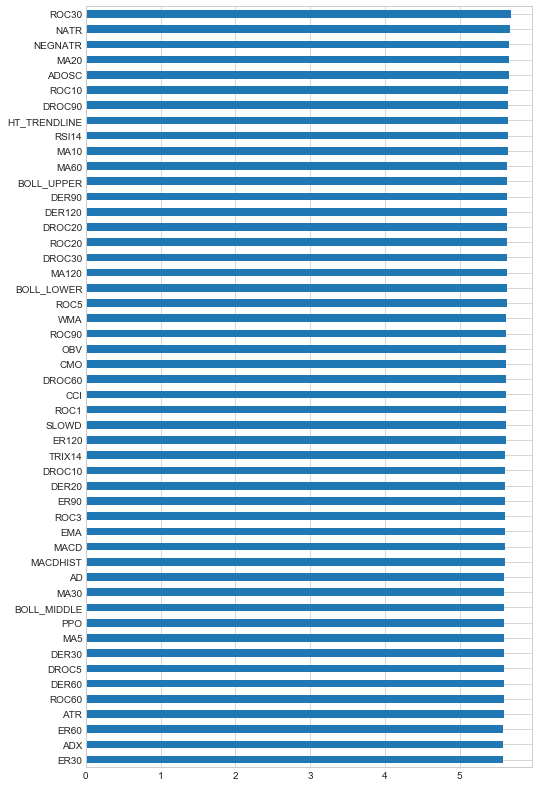

In [100]:
mi = {}
for feature in tqdm(features):
    tdf = df.loc[:, ['target', feature]].dropna().sample(n=100000,replace=True)
    discrete_features = tdf[feature].nunique() < 10
    mi[feature] = mutual_info_regression(X=tdf[[feature]],
                                         y=tdf.target,
                                         discrete_features=discrete_features)[0]
mi = pd.Series(mi)
mi.nlargest(50).sort_values().plot.barh(figsize=(8, 14))
mi.to_hdf('data.h5', 'mutual_information')

In [101]:
save_df = df.copy()

In [102]:
print(save_df)


           symbol            datetime exchange     open     high      low  \
119    1inch_usdt 2021-04-23 08:00:00  BINANCE   4.5850   4.6912   3.7536   
120    1inch_usdt 2021-04-24 08:00:00  BINANCE   4.2818   4.2834   3.9151   
121    1inch_usdt 2021-04-25 08:00:00  BINANCE   3.9509   4.2499   3.7850   
122    1inch_usdt 2021-04-26 08:00:00  BINANCE   3.9969   4.5754   3.9411   
123    1inch_usdt 2021-04-27 08:00:00  BINANCE   4.5488   5.1554   4.4605   
...           ...                 ...      ...      ...      ...      ...   
47183    ftt_usdt 2021-08-19 08:00:00  BINANCE  46.6370  49.8760  44.7280   
47184    ftt_usdt 2021-08-20 08:00:00  BINANCE  49.7670  53.7920  47.7200   
47185    ftt_usdt 2021-08-21 08:00:00  BINANCE  50.3290  52.0000  49.2140   
47186    ftt_usdt 2021-08-22 08:00:00  BINANCE  51.2670  51.9500  48.3650   
47187    ftt_usdt 2021-08-23 08:00:00  BINANCE  50.2260  51.9960  50.1630   

         close        volume     DROC5    DROC10  ...        SAR    AROON_U

In [104]:
from sklearn.model_selection import train_test_split

def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(), index=model.feature_name()))

def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better


df = save_df.copy()

df = df.set_index(["datetime","symbol"])

uniques = df.nunique()
categoricals = uniques[uniques < 20].index.tolist()
features = df.columns.difference(pd.Index(list(fwd_returns) + ['exchange']) ).tolist()
label = 'target'

X = df.loc[:, features]
y = df.loc[:, [label]]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              metric='None')
num_boost_round = 5000


feature_importance, ic, daily_ic = [], [], []

evals_result = {}
model = lgb.train(params=params,
                  train_set=train_data,
                  num_boost_round=num_boost_round,
                  valid_sets=[train_data, test_data],
                  valid_names=['train', 'valid'],
                  feval=ic_lgbm,
                  evals_result=evals_result,
                  early_stopping_rounds=500,
                  verbose_eval=100)
model.save_model(f'models/lgb_model.txt')

                           
# lgb_data = lgb.Dataset(data=df.loc[:, features],
#                        label=df.loc[:, label],
#                        categorical_feature=categoricals,
#                        free_raw_data=False)

# lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
#                            params=params).construct()
# lgb_test = lgb_data.subset(used_indices=test_idx.tolist(),
#                            params=params).construct()

# for train_idx, test_idx in [(use_train_idx, use_test_idx)]:
#     start = time()
#     lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
#                                params=params).construct()
#     lgb_test = lgb_data.subset(used_indices=test_idx.tolist(),
#                                params=params).construct()
#     evals_result = {}
#     model = lgb.train(params=params,
#                       train_set=lgb_train,
#                       num_boost_round=num_boost_round,
#                       valid_sets=[lgb_train, lgb_test],
#                       valid_names=['train', 'valid'],
#                       feval=ic_lgbm,
#                       evals_result=evals_result,
#                       early_stopping_rounds=500,
#                       verbose_eval=100)
#     model.save_model(f'models/lgb_model.txt')
#     fi = get_fi(model)
#     fi.to_hdf('data.h5', f'fi/{i:02}')
#     test_set = factors.iloc[test_idx, :]
#     X_test = test_set.loc[:, model.feature_name()]
#     y_test = test_set.loc[:, label]
#     y_pred = model.predict(X_test)
#     cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
#     cv_preds.to_hdf('preds.h5', f'preds/{i:02}')

#     by_day = cv_preds.groupby(level='date')
#     ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
#     daily_ic_mean = ic_by_day.mean()
#     daily_ic_median = ic_by_day.median()
#     ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
#     print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.206295	valid's ic: 0.170943
[200]	train's ic: 0.20842	valid's ic: 0.160844
[300]	train's ic: 0.213398	valid's ic: 0.167016
[400]	train's ic: 0.251331	valid's ic: 0.174369
[500]	train's ic: 0.295476	valid's ic: 0.195194
Early stopping, best iteration is:
[6]	train's ic: 0.235152	valid's ic: 0.21177


In [105]:
fi = get_fi(model)
fi.to_hdf('data.h5', f'fi/00')
X_test = x_test.loc[:, model.feature_name()]
Y_test = y_test.loc[:, label]
Y_pred = model.predict(X_test)
cv_preds = Y_test.to_frame('Y_test').assign(Y_pred=Y_pred)
cv_preds.to_hdf('preds.h5', f'preds/00')

by_day = cv_preds.groupby(level='datetime')
ic_by_day = by_day.apply(lambda x: spearmanr(x.Y_test, x.Y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.Y_test, cv_preds.Y_pred)[0]
print(f'\n{time()-start:6.1f} | {ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_median: 6.2%}')



906587.1 | 21.18% |  5.73% |  8.70%


In [106]:
import shap
shap.initjs()

# model = lgb.Booster(model_file='models/lgb_model.txt')
explainer = shap.TreeExplainer(model)

# workaround for SHAP version 0.30: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

shap_values = explainer.shap_values(df.iloc[train_idx, :].loc[:, model.feature_name()])
shap.summary_plot(shap_values,
                  df
                  .iloc[train_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()
plt.gcf().savefig(results_path / 'shap_summary_dot', dpi=300)

shap_values = pd.DataFrame(shap_values, columns = features)

shap_summary = shap_values.abs().mean()
shap_summary /= shap_summary.sum()


IndexError: positional indexers are out-of-bounds

In [ ]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))
shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')
fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')
mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91)
fig.savefig(results_path / 'all_feature_metrics');
